# Predicting the future in eight steps

In [1]:
#  Libraries used in the project
import yfinance as yf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import mplfinance as mpf

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

##### Step 1: Data Collection

In [2]:
# Define ticker name. It is the place where you can test different stocks.
ticker_name = 'TSLA'

# Define the start and end dates
start_date = '2021-01-01'
end_date = '2023-03-30'

# Download the historical stock price data for Tesla from Yahoo Finance
tesla_data = yf.Ticker(ticker_name).history(period='1d', start=start_date, end=end_date)

##### Step 2: Data Preprocessing
##### Data preprocessing is a critical step in machine learning that involves transforming raw data into a format that can be easily used by a machine learning model. The goal of data preprocessing is to make sure that the data is accurate, complete, and in a format that is suitable for the chosen machine learning algorithm.

In [3]:
# I remove all the data that I do not need for this calculation
tesla_data = tesla_data.drop('Stock Splits', axis=1)
tesla_data = tesla_data.drop('Dividends', axis=1)
tesla_data = tesla_data.dropna()

##### Step 3: Feature Engineering
##### In simpler terms, it involves analyzing the available data, identifying the most relevant and informative features, and modifying or creating new features to better represent the patterns and relationships within the data. This process can include tasks such as data cleaning, normalization, encoding categorical variables, scaling, and feature extraction.
##### It is much simpler to read SMA (Simple Moving Average) than changes in stock price, and it will be much simpler to predict the moving average than the raw stock price."

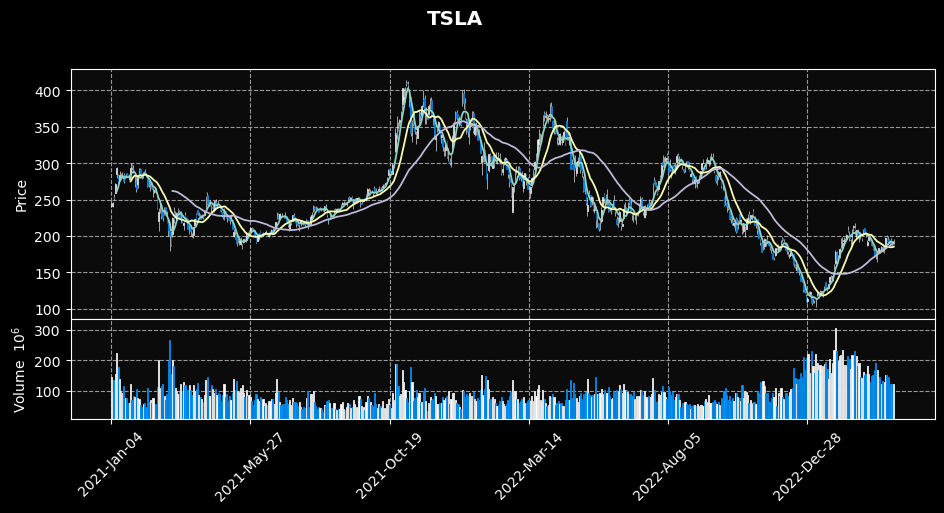

In [4]:
tesla_data["SMA_5"] = tesla_data["Close"].rolling(window=5).mean()
tesla_data["SMA_15"] = tesla_data["Close"].rolling(window=15).mean()
tesla_data["SMA_45"] = tesla_data["Close"].rolling(window=45).mean()
sma_5 = mpf.make_addplot(tesla_data[["SMA_5"]])
sma_15 = mpf.make_addplot(tesla_data[["SMA_15"]])
sma_45 = mpf.make_addplot(tesla_data[["SMA_45"]])

# Data visualization is an important step in the machine learning process, typically done during the exploratory data analysis phase before developing a model.
mpf.plot(
    tesla_data, 
    type='candle', 
    addplot = [sma_5, sma_15, sma_45],
    volume=True, 
    title=ticker_name, 
    style='nightclouds', 
    figsize=(12,5))

##### Step 4: Split Data
##### In machine learning, it is important to split the available data into separate training and testing sets. The purpose of this is to evaluate the performance of the trained model on new, unseen data.

##### The training data is used to train the model, while the testing data is used to evaluate its performance. By splitting the data into these separate sets, we can assess how well the model is able to generalize to new, unseen data.

In [5]:
train_data = tesla_data[:'2023-03-01']
test_data = tesla_data['2023-03-01':]

##### Step 5: Model Selection
##### ARIMA (AutoRegressive Integrated Moving Average) is a statistical model used in machine learning for time series forecasting. The model can be used to make predictions about future values in a time series based on patterns and trends in the historical data.

##### ARIMA models are suitable for time series data that exhibit autocorrelation (i.e. where the value of a given point in time is correlated with the values of previous points in time), and where the data may exhibit trends and/or seasonality.

##### ARIMA models use three parameters: p, d, and q. The p parameter represents the order of the autoregressive (AR) component, the d parameter represents the degree of differencing required to make the data stationary, and the q parameter represents the order of the moving average (MA) component.

##### ARIMA models are commonly used in fields such as finance, economics, and environmental science to make predictions about future values in a time series.

#### I will prepare three models, respectively for the moving average of 5, 15, and 45 quotes. In this way, we will check how changes in the q parameter affect the ARIMA model."


In [6]:
model_5 = ARIMA(train_data['Close'].values, order=(1, 1, 5))
model_15 = ARIMA(train_data['Close'].values, order=(1, 1, 15))
model_45 = ARIMA(train_data['Close'].values, order=(1, 1, 45))

##### Step 6: Model Training
##### Caution! It can take some time.

In [7]:
model_5_fit = model_5.fit()
model_15_fit = model_15.fit()
model_45_fit = model_45.fit()

C:\Users\Romek\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Romek\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### Step 7: Model Evaluation
##### Model evaluation is an essential part of the data science workflow, as it helps to assess the performance of a machine learning model and its ability to generalize to new, unseen data.

In [8]:
#  I need a data frame because later I will display the model on a chart. The plot function requires a data frame as input.
predictions_5 = model_5_fit.forecast(len(test_data))
predictions_5 = pd.DataFrame(predictions_5)
predictions_5.columns = ['Close']
predictions_5.index = test_data.index

predictions_15 = model_15_fit.forecast(len(test_data))
predictions_15 = pd.DataFrame(predictions_15)
predictions_15.columns = ['Close']
predictions_15.index = test_data.index

predictions_45 = model_45_fit.forecast(len(test_data))
predictions_45 = pd.DataFrame(predictions_45)
predictions_45.columns = ['Close']
predictions_45.index = test_data.index

mse = mean_squared_error(test_data["Close"].values, predictions_5['Close'].values)
print(f"Mean Squared Error for q = 5 model: {mse:.2f}")

mse = mean_squared_error(test_data["Close"].values, predictions_15['Close'].values)
print(f"Mean Squared Error for q = 15 model: {mse:.2f}")

mse = mean_squared_error(test_data["Close"].values, predictions_45['Close'].values)
print(f"Mean Squared Error for q = 45 model: {mse:.2f}")

Mean Squared Error for q = 5 model: 300.62
Mean Squared Error for q = 15 model: 244.95
Mean Squared Error for q = 45 model: 145.10


##### Step 8: Model Deployment
##### Model deployment refers to the process of making a machine learning model available for use in a production environment. This involves taking a model that has been trained and tested in a development or experimental setting, and integrating it into a system where it can be used to make predictions on real-world data.

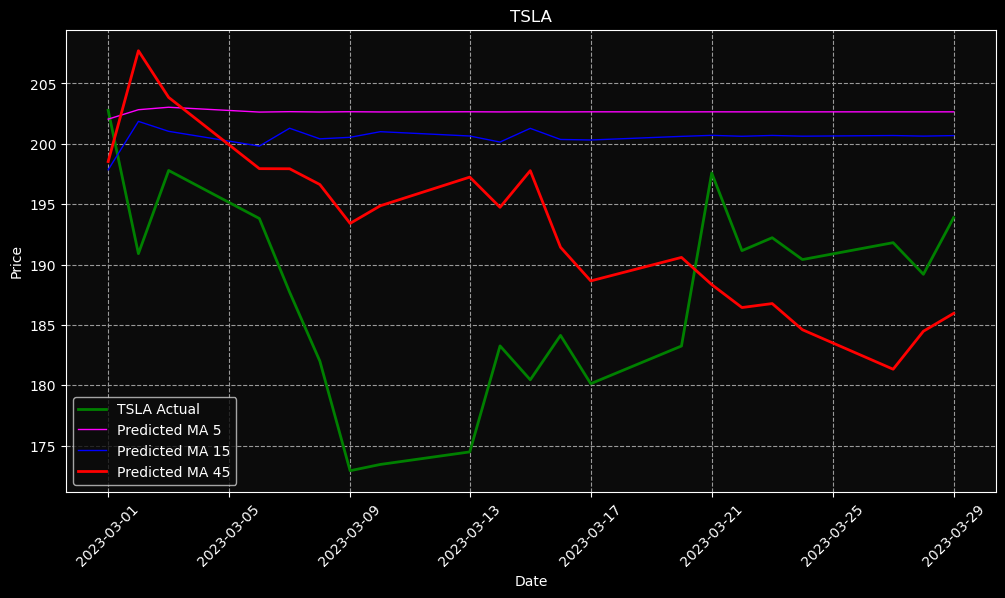

In [9]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(test_data.index, test_data["Close"], color='green', lw=2)
plt.xticks(rotation=45)

plt.title(f'{ticker_name}')
plt.ylabel('Price')
plt.xlabel('Date')
plt.plot(predictions_5.index, predictions_5, color='magenta')
plt.plot(predictions_15.index, predictions_15, color='blue')
plt.plot(predictions_45.index, predictions_45, color='red', lw=2)
plt.legend([f'{ticker_name} Actual', 'Predicted MA 5', 'Predicted MA 15', 'Predicted MA 45'])

plt.show()

##### Can I predict stock prices? No, I can't.
##### Can I use the ARIMA model? I have used it in this material.
##### The ARIMA model can be used for predicting sales, changes in stock prices, demand forecasting, predicting electricity demand, or predicting website traffic. This list is not exhaustive.

##### These are just a few examples of how ARIMA models can be used in business. Anywhere there is a time series dataset that requires forecasting, ARIMA models can be a valuable tool.
##### In what field would you like to be able to predict the future?